In [2]:
# Chargement des librairies nécessaires
library(ggplot2)
library(tidyverse)
library(gridExtra)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR) 
library(factoextra)
library(glmnet) 
library(ggfortify)
library(pROC)
library(ROCR)
library(repr)
library(caret)

# fix random seed for reproducibility
set.seed(1234)

## GRAPH SETTINGS ##
# Save original parameters (optional)
original_par <- par(no.readonly = TRUE)

# Set global scaling factors (1.5x default size)
par(
  cex.lab = 1.5,   # Axis labels
  cex.axis = 1.5,  # Axis text (tick labels)
  cex.main = 1.5,  # Main title
  cex.sub = 1.5    # Subtitle
)

# Define a custom theme with larger fonts
custom_theme <- theme(
  text = element_text(size = 16),            # Global text size
  axis.title = element_text(size = 18),      # Axis labels
  axis.text = element_text(size = 14),       # Axis tick labels
  plot.title = element_text(size = 20),      # Main title
  plot.subtitle = element_text(size = 16)    # Subtitle
)

# Apply the theme to all future plots
theme_set(custom_theme)


## DATA LOADING & PROCESSING ##
# Load data
path <- "../../" # modifier le nombre de ../ si nécessaire
gym <- read.table(paste(path, "gym_members_exercise_tracking.csv", sep = ""),
                    sep = ",", header = TRUE)

gym[,'Gender'] <- as.factor(gym[,'Gender'])
gym[,'Workout_Type'] <- as.factor(gym[,'Workout_Type'])
gym[,'Experience_Level'] <- as.factor(gym[,'Experience_Level'])
gym[,'Workout_Frequency..days.week.'] <- as.factor(gym[,'Workout_Frequency..days.week.'])

gym[, "Weight..kg."] <- log(gym[,"Weight..kg."])

max_fat <- max(gym[,"Fat_Percentage"])
gym[, "Fat_Percentage"] <- sqrt((max_fat + 1) - gym[,"Fat_Percentage"])

# renome les variables Weight..kg. et BMI en LWeight et LBMI
names(gym)[names(gym) == "Weight..kg."] <- "LWeight"
names(gym)[names(gym) == "Fat_Percentage"] <- "SFat_Percentage"

gym <- gym %>% select(-c(BMI))

# divide data into training and testing sets for experience level
trainIndex <- createDataPartition(gym$Experience_Level, p = .8, 
                                  list = FALSE, 
                                  times = 1)
gym_train <- gym[ trainIndex,]
gym_test  <- gym[-trainIndex,]

# Normalize the data
gym_train_scaled = gym_train
scaler <- scale(gym_train[,-c(2,10,13,14)])

# Extract the center and scale attributes
center <- attr(scaler, "scaled:center")
scale <- attr(scaler, "scaled:scale")

gym_train_scaled[,-c(2,10,13,14)] <- scale(gym_train[,-c(2,10,13,14)], center = center, scale = scale)

gym_test_scaled = gym_test
gym_test_scaled[,-c(2,10,13,14)] <- scale(gym_test[,-c(2,10,13,14)], center = center, scale = scale)


cat("Data loaded and preprocessed")


## FUNCTION DEFINITIONS ##

# Function to plot residuals
# x: predicted values
# y: residuals
gplot.res <- function(x, y, titre = "titre"){
    ggplot(data.frame(x=x, y=y),aes(x,y))+
    geom_point(col = "blue")+#xlim(0, 250)+ylim(-155, 155)+
    ylab("Résidus")+ xlab("Valeurs prédites")+
    ggtitle(titre)+
    geom_hline(yintercept = 0,col="green")
}

# Function to plot ROC curve
# model: model to evaluate
# data: data to evaluate
# title: title of the plot
plot_roc <- function(model, data, title = "ROC curve"){
    pred <- predict(model, data, type = "response")
    roc <- roc(data$Experience_Level, pred)
    auc <- round(auc(roc), 2)
    plot(roc, main = title)
    text(0.8, 0.2, paste("AUC = ", auc), cex = 1.5)
}

Warning message:
"le package 'ggplot2' a été compilé avec la version R 4.3.3"
Warning message:
"le package 'tidyverse' a été compilé avec la version R 4.3.3"
Warning message:
"le package 'tibble' a été compilé avec la version R 4.3.3"
Warning message:
"le package 'tidyr' a été compilé avec la version R 4.3.3"
Warning message:
"le package 'readr' a été compilé avec la version R 4.3.3"
Warning message:
"le package 'purrr' a été compilé avec la version R 4.3.3"
Warning message:
"le package 'dplyr' a été compilé avec la version R 4.3.3"
Warning message:
"le package 'stringr' a été compilé avec la version R 4.3.3"
Warning message:
"le package 'forcats' a été compilé avec la version R 4.3.3"
Warning message:
"le package 'lubridate' a été compilé avec la version R 4.3.3"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ 

Data loaded and preprocessed

In [3]:
summary(gym_train_scaled)
summary(gym_test_scaled)

      Age              Gender       LWeight           Height..m.      
 Min.   :-1.70033   Female:384   Min.   :-2.06411   Min.   :-1.74278  
 1st Qu.:-0.88351   Male  :395   1st Qu.:-0.70877   1st Qu.:-0.79206  
 Median : 0.09668                Median :-0.05133   Median :-0.07902  
 Mean   : 0.00000                Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 0.91350                3rd Qu.: 0.67508   3rd Qu.: 0.55479  
 Max.   : 1.64864                Max.   : 2.18326   Max.   : 2.21854  
    Max_BPM            Avg_BPM          Resting_BPM      
 Min.   :-1.70393   Min.   :-1.66558   Min.   :-1.66962  
 1st Qu.:-0.84195   1st Qu.:-0.90414   1st Qu.:-0.84618  
 Median : 0.02003   Median :-0.07349   Median :-0.02273  
 Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.: 0.88201   3rd Qu.: 0.89561   3rd Qu.: 0.80072  
 Max.   : 1.65779   Max.   : 1.72627   Max.   : 1.62417  
 Session_Duration..hours. Calories_Burned     Workout_Type SFat_Percentage   
 Min.   :-2.20445  

      Age              Gender       LWeight           Height..m.      
 Min.   :-1.70033   Female: 78   Min.   :-2.06411   Min.   :-1.74278  
 1st Qu.:-0.88351   Male  :116   1st Qu.:-0.74142   1st Qu.:-0.71283  
 Median :-0.06669                Median :-0.01540   Median :-0.07902  
 Mean   :-0.05448                Mean   : 0.03039   Mean   : 0.10352  
 3rd Qu.: 0.66845                3rd Qu.: 0.77183   3rd Qu.: 0.95092  
 Max.   : 1.64864                Max.   : 2.14138   Max.   : 2.21854  
    Max_BPM            Avg_BPM         Resting_BPM      
 Min.   :-1.70393   Min.   :-1.6656   Min.   :-1.66962  
 1st Qu.:-0.66956   1st Qu.:-0.9041   1st Qu.:-0.84618  
 Median : 0.10623   Median :-0.1427   Median : 0.11451  
 Mean   : 0.05024   Mean   :-0.1024   Mean   : 0.03953  
 3rd Qu.: 0.88201   3rd Qu.: 0.7399   3rd Qu.: 0.93796  
 Max.   : 1.65779   Max.   : 1.6571   Max.   : 1.62417  
 Session_Duration..hours. Calories_Burned      Workout_Type SFat_Percentage   
 Min.   :-2.17545        

### Linear Regression

#### Sans selection


Call:
lm(formula = Calories_Burned ~ ., data = gym_train_scaled)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.47154 -0.09373 -0.00760  0.07968  0.63471 

Coefficients:
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    -0.1620832  0.0212259  -7.636 6.73e-14 ***
Age                            -0.1507445  0.0053571 -28.139  < 2e-16 ***
GenderMale                      0.3303012  0.0216668  15.245  < 2e-16 ***
LWeight                         0.0086219  0.0066054   1.305    0.192    
Height..m.                      0.0020423  0.0065248   0.313    0.754    
Max_BPM                         0.0015636  0.0053842   0.290    0.772    
Avg_BPM                         0.3287440  0.0053642  61.285  < 2e-16 ***
Resting_BPM                     0.0087330  0.0053581   1.630    0.104    
Session_Duration..hours.        0.8930857  0.0087344 102.249  < 2e-16 ***
Workout_TypeHIIT                0.0049799  0.0152041   0.328    0.743    
W

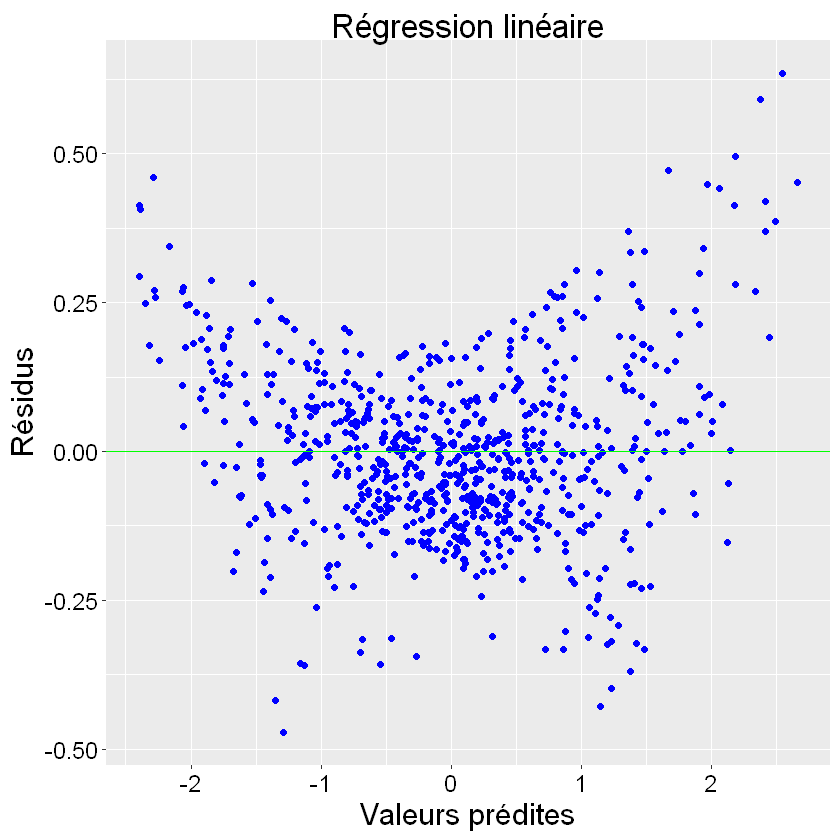

In [4]:
reg.lm <- lm(Calories_Burned ~ ., data = gym_train_scaled)

# Summary of the regression
summary(reg.lm)

# Extract the residuals
sel.lm <- reg.lm$residuals
fit.lm <- reg.lm$fitted.values

# Plot the residuals
gplot.res(fit.lm, sel.lm, "Régression linéaire")

In [5]:
# MSE of the model on the training and test set
mse_train <- mean(sel.lm^2)
mse_test <- mean((predict(reg.lm, gym_test_scaled) - gym_test_scaled$Calories_Burned)^2)

cat("MSE on training set: ", mse_train, "\n")
cat("MSE on test set: ", mse_test, "\n")

MSE on training set:  0.02144403 
MSE on test set:  0.01608908 


**Interprétation** : Giga trompette, on va rajouter des termes quadratiques

#### LASSO

,Age,GenderFemale,GenderMale,LWeight,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Workout_TypeHIIT,Workout_TypeStrength,Workout_TypeYoga,SFat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.3,Workout_Frequency..days.week.4,Workout_Frequency..days.week.5,Experience_Level2,Experience_Level3
2,0.58677041,1,0,0.19779559,-1.5050986225,-0.06617008,0.4802851,0.5262388,0.11582778,1,0,0,-1.7625553,-0.8567881,0,1,0,1,0
3,-0.55678178,1,0,-0.14540416,-0.4751551297,-1.10054779,-1.5271377,-1.1206579,-0.43523841,0,0,0,-1.5948489,-0.5262097,0,1,0,1,0
5,-0.06668799,0,1,-1.55230634,0.5547883631,0.70961321,0.9648354,0.8007216,-1.79840214,0,1,0,-0.5728511,0.3002366,1,0,0,0,0
6,1.40359340,1,0,-0.72427809,-0.3167022846,-1.01434964,0.8263925,1.6241700,0.95692880,1,0,0,1.3988024,0.1349473,0,0,1,0,1
7,-0.23005259,0,1,-0.03075534,0.0002034054,-0.49716079,1.7262717,1.4869286,0.66689396,0,0,0,0.6865113,-0.5262097,1,0,0,1,0
8,0.09667661,1,0,-0.06166344,-1.6635514675,0.79581135,-0.2119297,0.2517560,0.02881733,0,0,0,-0.8643778,-1.1873666,1,0,0,1,0


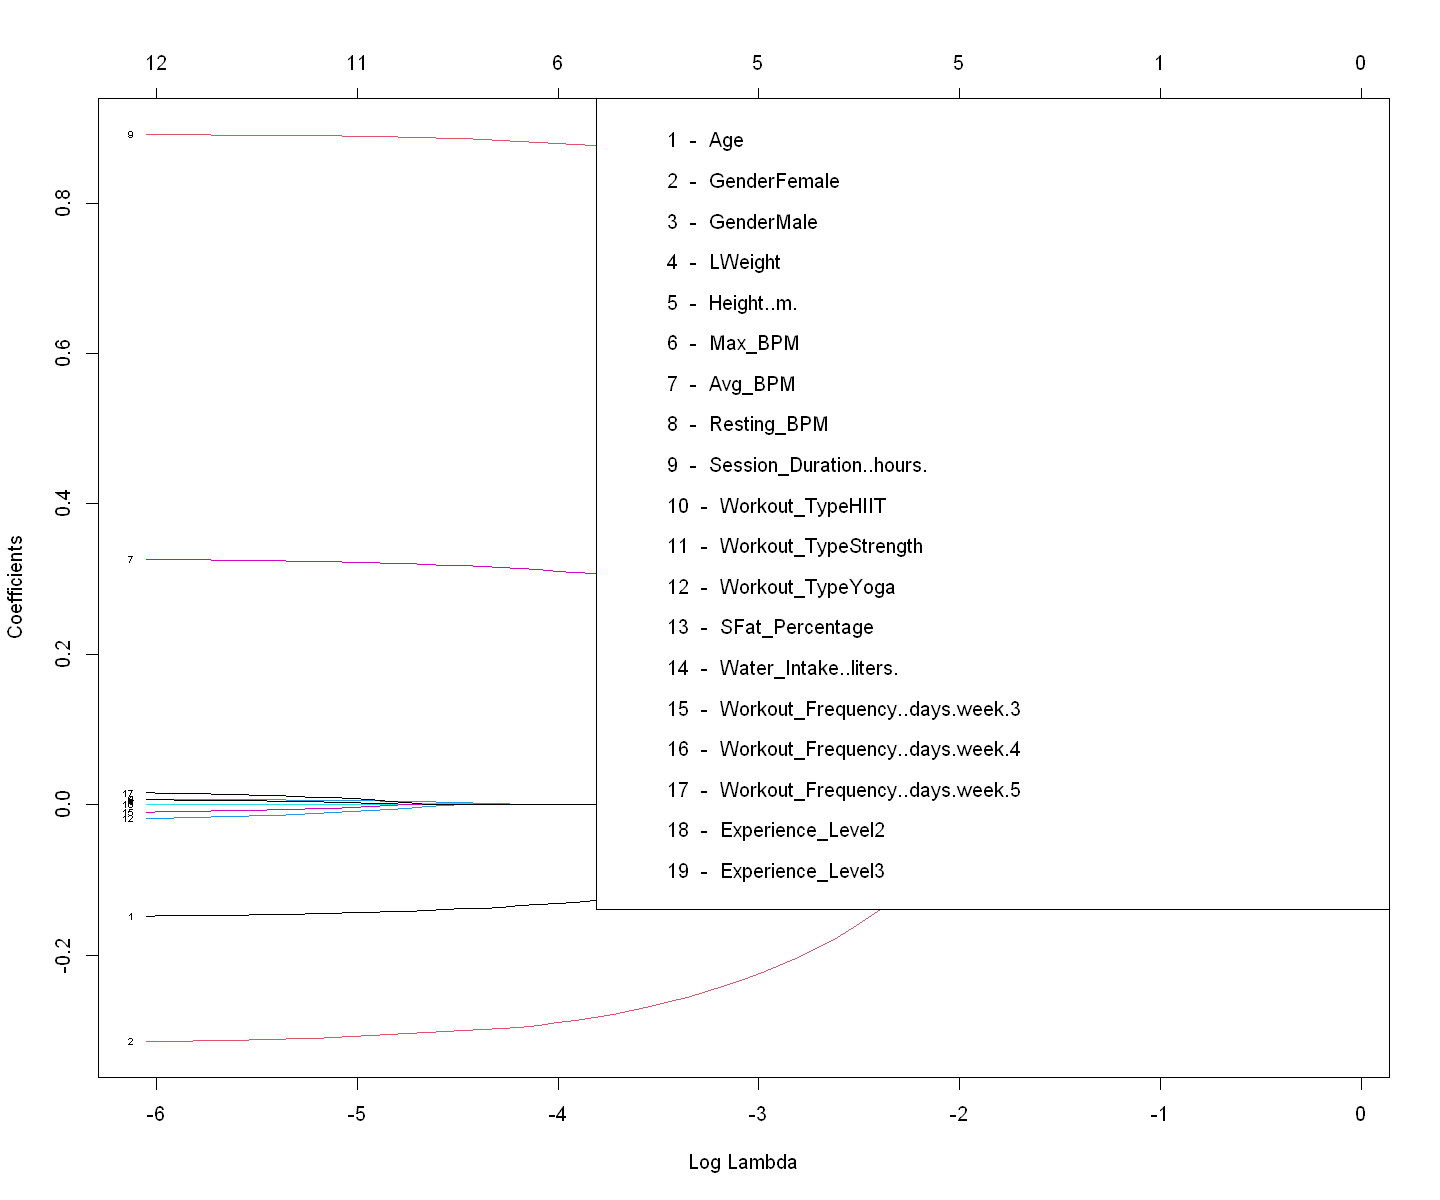

In [6]:
x.mat <- model.matrix(Calories_Burned ~ . -1, data = gym_train_scaled)
y.vec <- gym_train_scaled$Calories_Burned

head(x.mat)

# Fit the lasso model
reg.lasso <- glmnet(x.mat, y.vec, alpha = 1, nfolds = 10) # alpha = 1 for lasso

# Plot the coefficients
options(repr.plot.width=12, repr.plot.height=10)
plot(reg.lasso, xvar = "lambda", label = TRUE)
legend("topright", 
       legend = paste(1:ncol(x.mat), " - ", colnames(x.mat)))



Call:  cv.glmnet(x = x.mat, y = y.vec, nfolds = 10, alpha = 1) 

Measure: Mean-Squared Error 

      Lambda Index Measure       SE Nonzero
min 0.003417    61 0.02257 0.002322      10
1se 0.024106    40 0.02476 0.003223       5

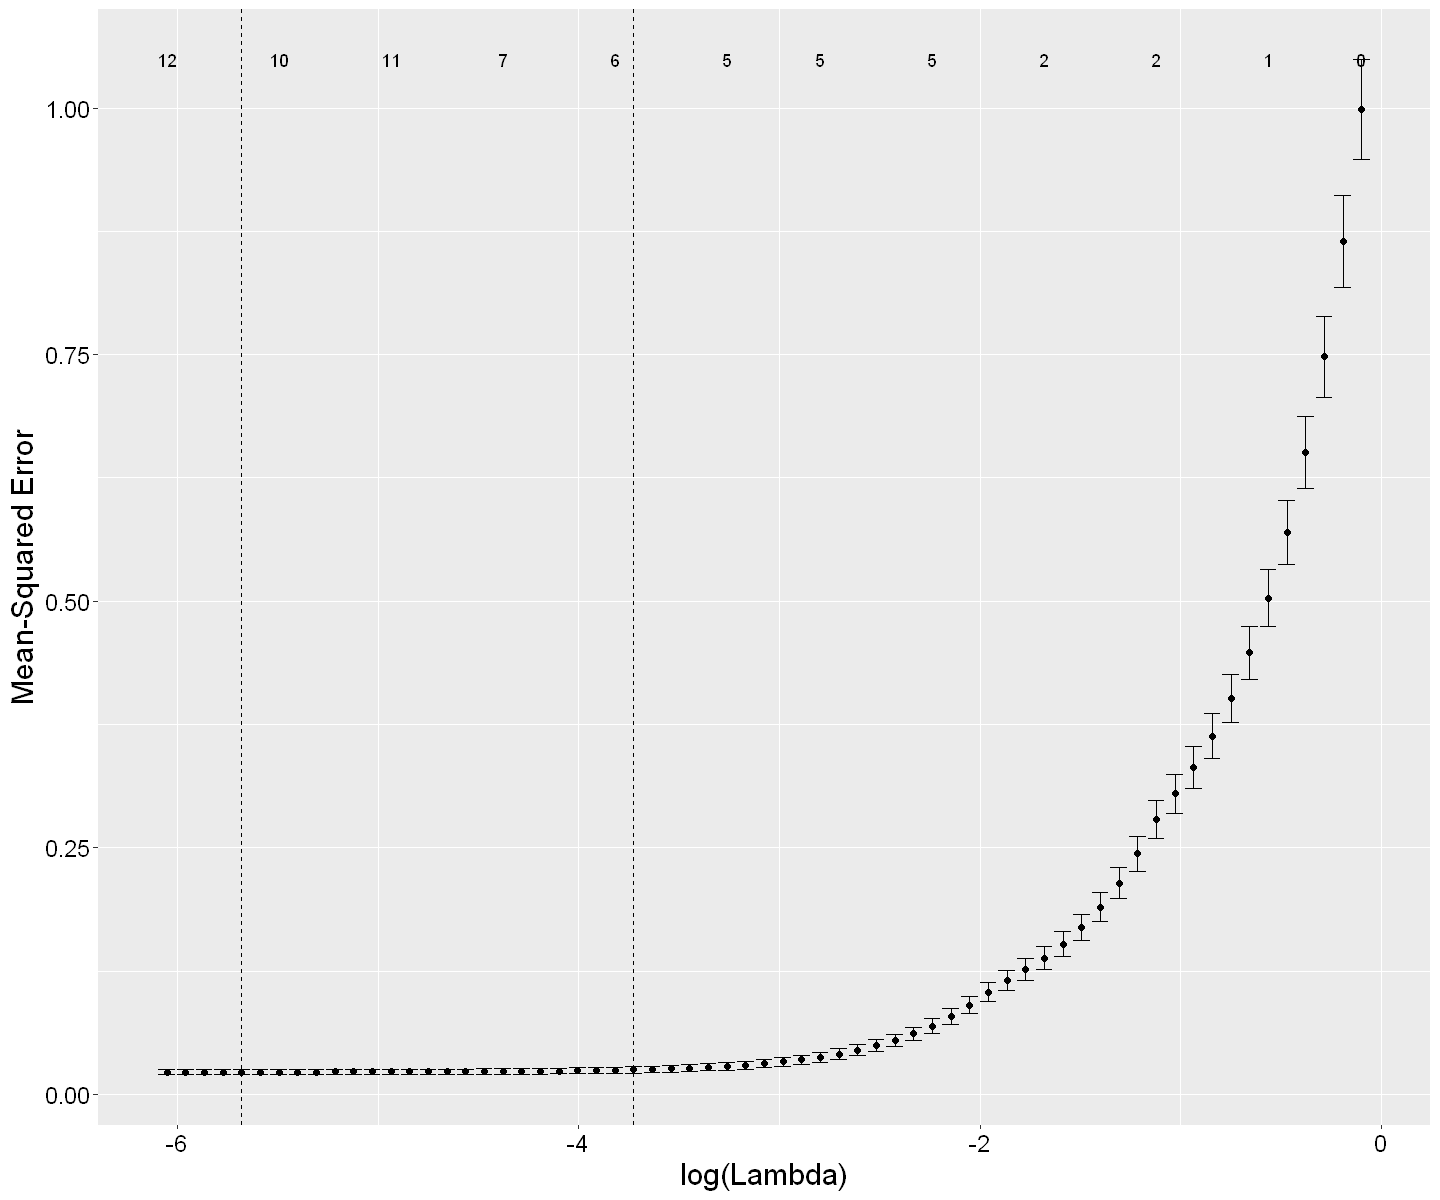

In [7]:
# Cross-validation
reg.lasso.cv <- cv.glmnet(x.mat, y.vec, alpha = 1, nfolds = 10)
reg.lasso.cv
autoplot(reg.lasso.cv)

In [8]:
cat("Best lambda: ", round(reg.lasso.cv$lambda.min,5), "\t \t")
cat("MSE for best lambda: ", round(reg.lasso.cv$cvm[which.min(reg.lasso.cv$cvm)],5), "\n")
cat("Best lambda 1se: ", round(reg.lasso.cv$lambda.1se,5), "\t")
cat("MSE for best lambda 1se: ", round(reg.lasso.cv$cvm[which.min(reg.lasso.cv$cvm)],5), "\n")


# Extract the best model
coef(reg.lasso.cv, s = "lambda.1se")

Best lambda:  0.00342 	 	MSE for best lambda:  0.02257 
Best lambda 1se:  0.02411 	MSE for best lambda 1se:  0.02257 


20 x 1 sparse Matrix of class "dgCMatrix"
                                          s1
(Intercept)                     1.372096e-01
Age                            -1.250175e-01
GenderFemale                   -2.783496e-01
GenderMale                      3.172129e-14
LWeight                         .           
Height..m.                      .           
Max_BPM                         .           
Avg_BPM                         3.048149e-01
Resting_BPM                     .           
Session_Duration..hours.        8.740339e-01
Workout_TypeHIIT                .           
Workout_TypeStrength            .           
Workout_TypeYoga                .           
SFat_Percentage                 .           
Water_Intake..liters.           .           
Workout_Frequency..days.week.3  .           
Workout_Frequency..days.week.4  .           
Workout_Frequency..days.week.5  .           
Experience_Level2               .           
Experience_Level3               .           

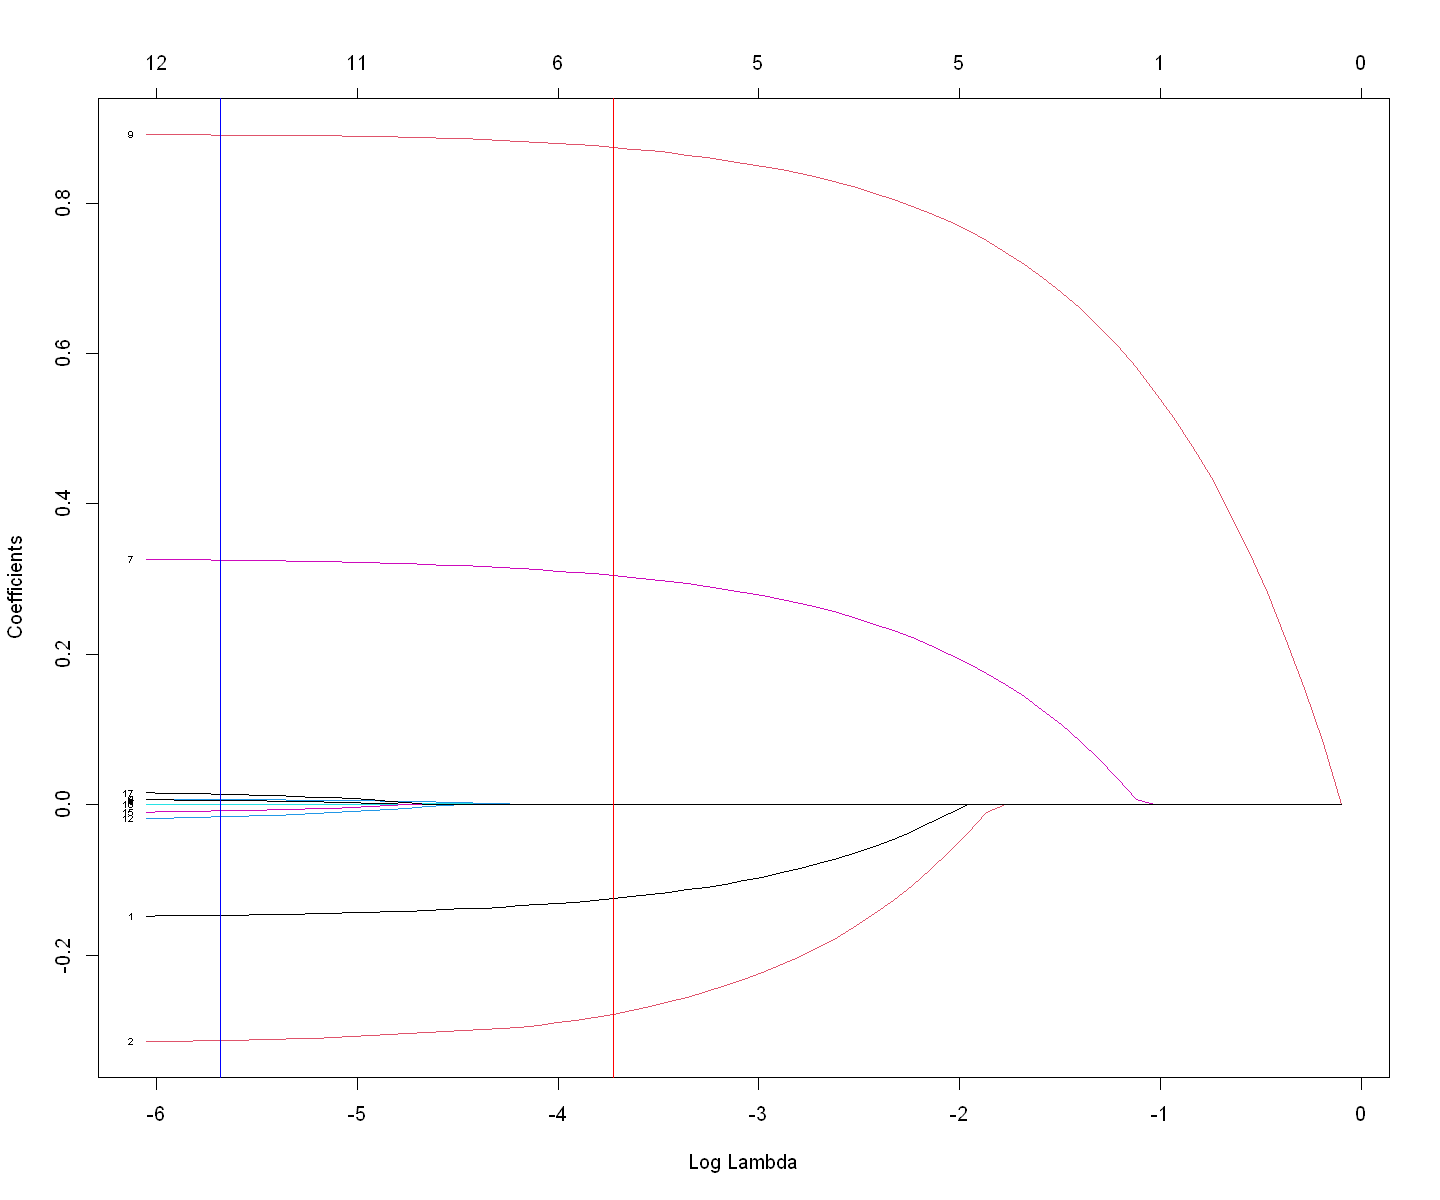

In [9]:
plot(reg.lasso, xvar = "lambda", label = TRUE)
abline(v=log(reg.lasso.cv$lambda.1se),col="red")
abline(v=log(reg.lasso.cv$lambda.min),col="blue")

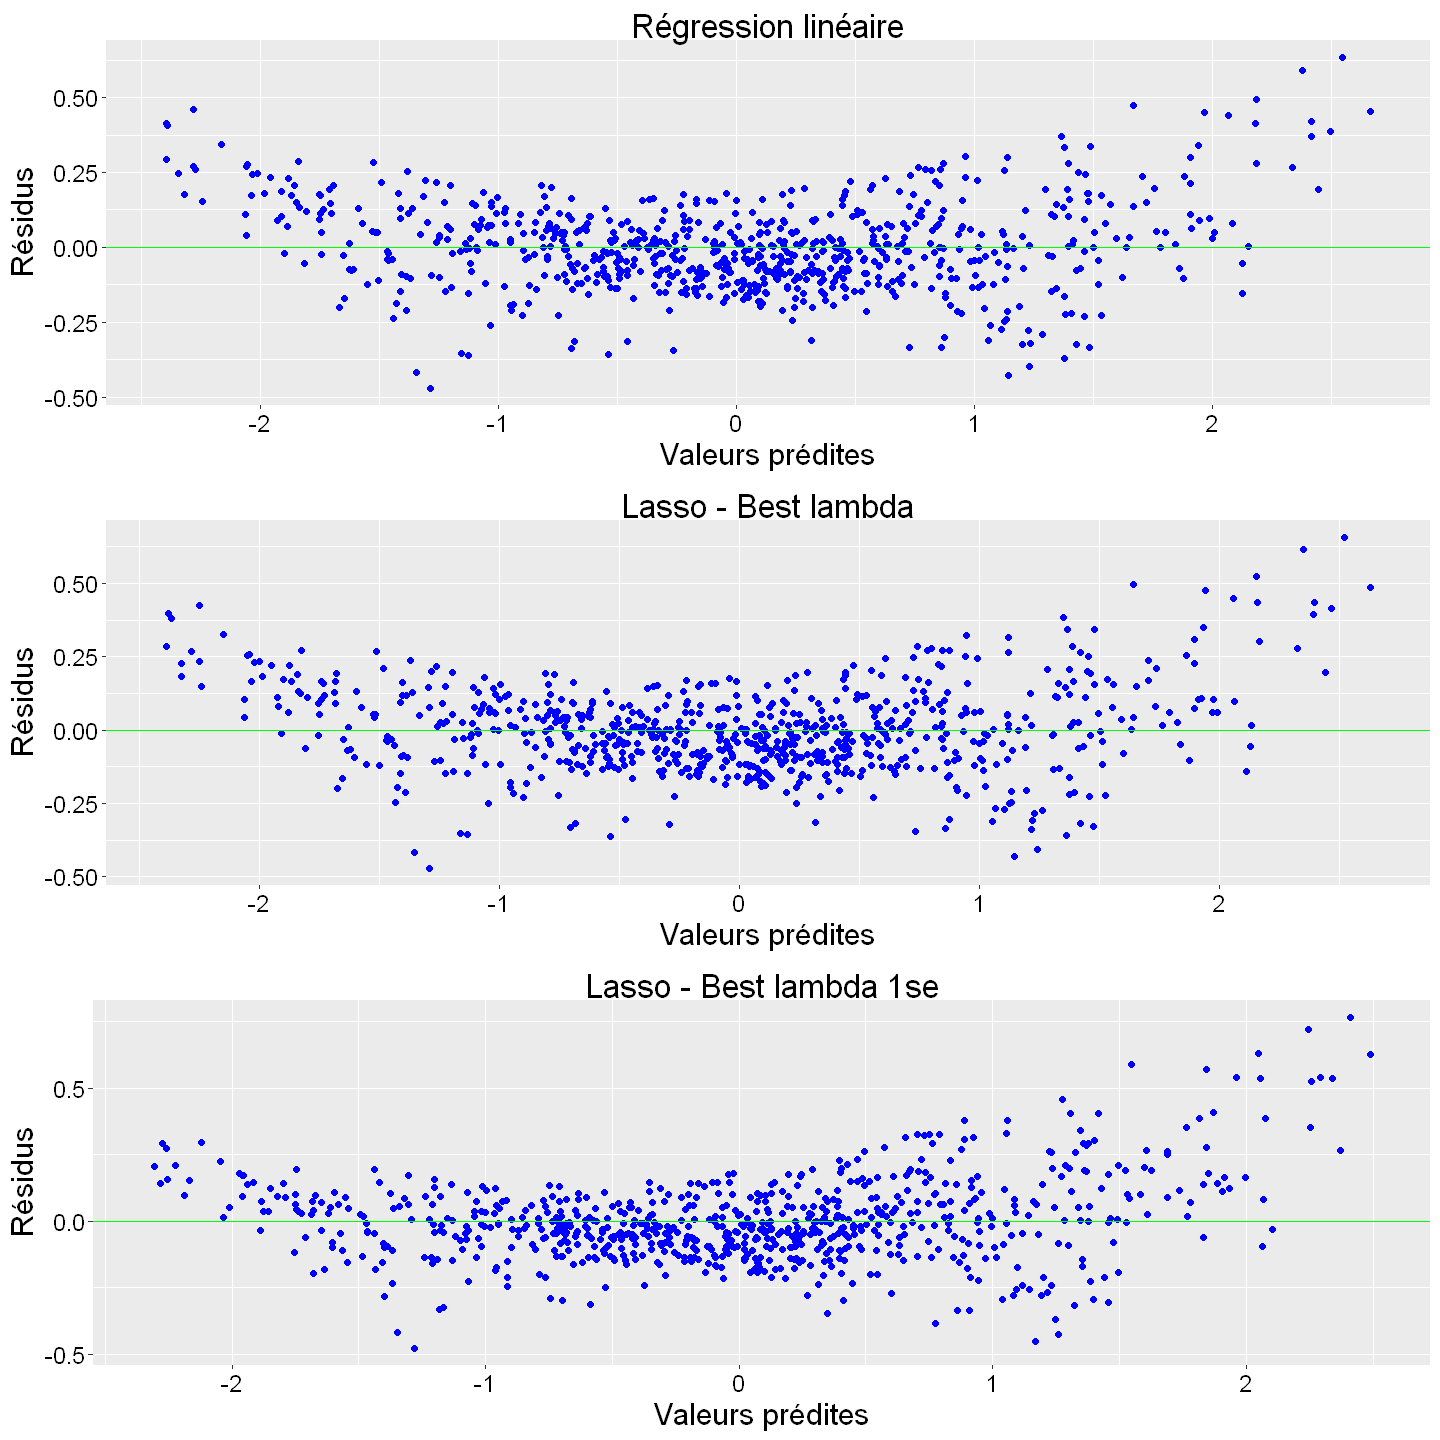

In [10]:
# Extract fitted values and residuals
fit.lasso.min <- predict(reg.lasso.cv, s = "lambda.min", newx = x.mat)
res.lasso.min <- y.vec - fit.lasso.min

fit.lasso.1se <- predict(reg.lasso.cv, s = "lambda.1se", newx = x.mat)
res.lasso.1se <- y.vec - fit.lasso.1se

# Plot the residuals
options(repr.plot.width=12, repr.plot.height=12)
p0 <- gplot.res(fit.lm, sel.lm, "Régression linéaire")
p1 <- gplot.res(fit.lasso.min, res.lasso.min, "Lasso - Best lambda")
p2 <- gplot.res(fit.lasso.1se, res.lasso.1se, "Lasso - Best lambda 1se")

grid.arrange(p0, p1, p2, ncol = 1)
rm(p0, p1, p2)

### Modèle Quadratique

In [11]:
# Quadratic model with lasso
x.mat.quad <- model.matrix(Calories_Burned ~ .^2 -1, data = gym_train_scaled)
reg.lasso.quad.cv <- cv.glmnet(x.mat.quad, y.vec, alpha = 1, nfolds = 10)
reg.lasso.quad.cv 
# coef(reg.lasso.quad.cv, s = "lambda.1se")


Call:  cv.glmnet(x = x.mat.quad, y = y.vec, nfolds = 10, alpha = 1) 

Measure: Mean-Squared Error 

      Lambda Index  Measure        SE Nonzero
min 0.002146    66 0.009141 0.0005331      61
1se 0.009508    50 0.009667 0.0006276      21

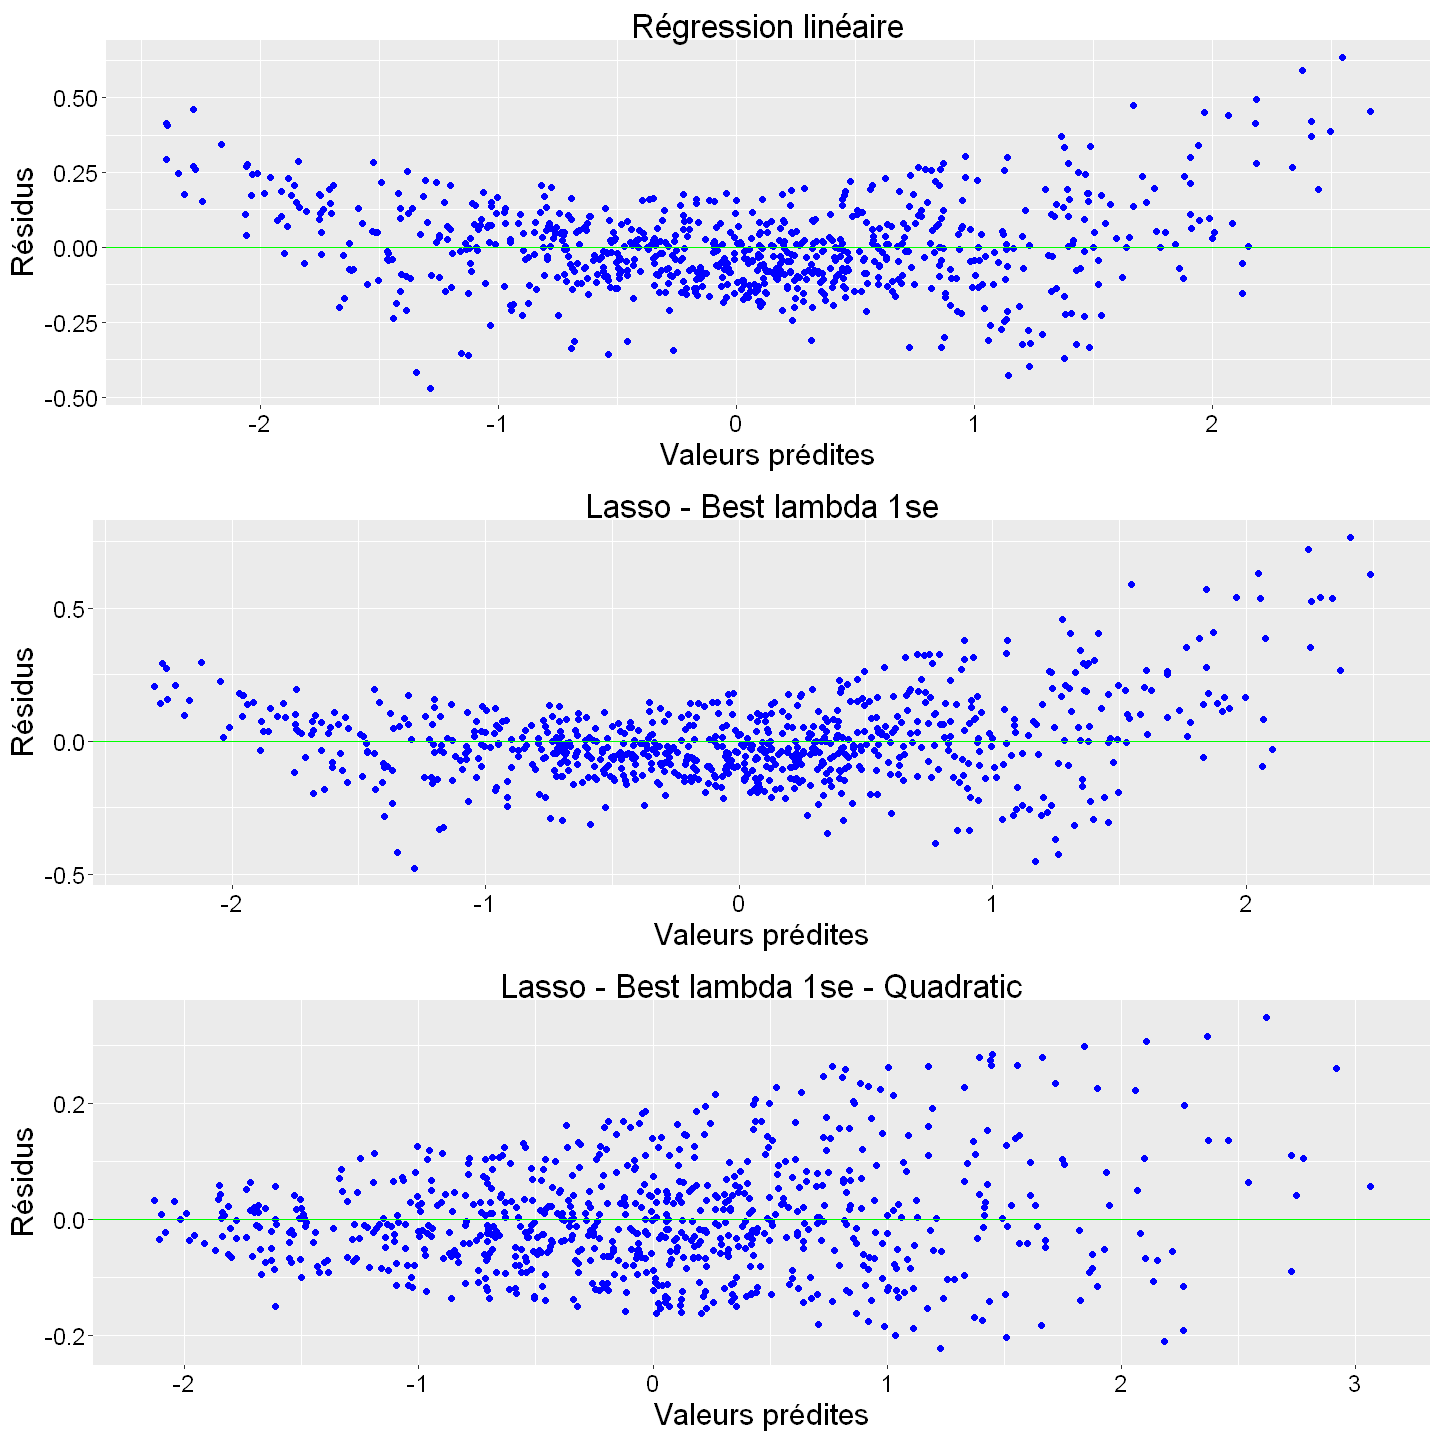

In [12]:
fit.lasso.quad.1se <- predict(reg.lasso.quad.cv, s = "lambda.1se", newx = x.mat.quad)
res.lasso.quad.1se <- y.vec - fit.lasso.quad.1se

# Plot the residuals
options(repr.plot.width=12, repr.plot.height=12)
p0 <- gplot.res(fit.lm, sel.lm, "Régression linéaire")
p1 <- gplot.res(fit.lasso.1se, res.lasso.1se, "Lasso - Best lambda 1se")
p2 <- gplot.res(fit.lasso.quad.1se, res.lasso.quad.1se, "Lasso - Best lambda 1se - Quadratic")

grid.arrange(p0, p1, p2, ncol = 1)
rm(p0, p1, p2)

### Support Vector Machines

In [13]:
library(e1071)

# SVM for regression
svm.reg0 <- svm(Calories_Burned ~ ., data = gym_train_scaled, cross = 5)
summary(svm.reg0)

Warning message in cret$cresults * scale.factor:
"Le recyclage d’un tableau (array) de longueur 1 dans un calcul arithmétique vecteur-tableau est obsolète.
  Utilisez c() ou as.vector() à la place.
"



Call:
svm(formula = Calories_Burned ~ ., data = gym_train_scaled, cross = 5)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.05263158 
    epsilon:  0.1 


Number of Support Vectors:  317



5-fold cross-validation on training data:

Total Mean Squared Error: 0.02004878 
Squared Correlation Coefficient: 0.9803508 
Mean Squared Errors:
 0.02455288 0.01902644 0.01913765 0.01659293 0.02096286 




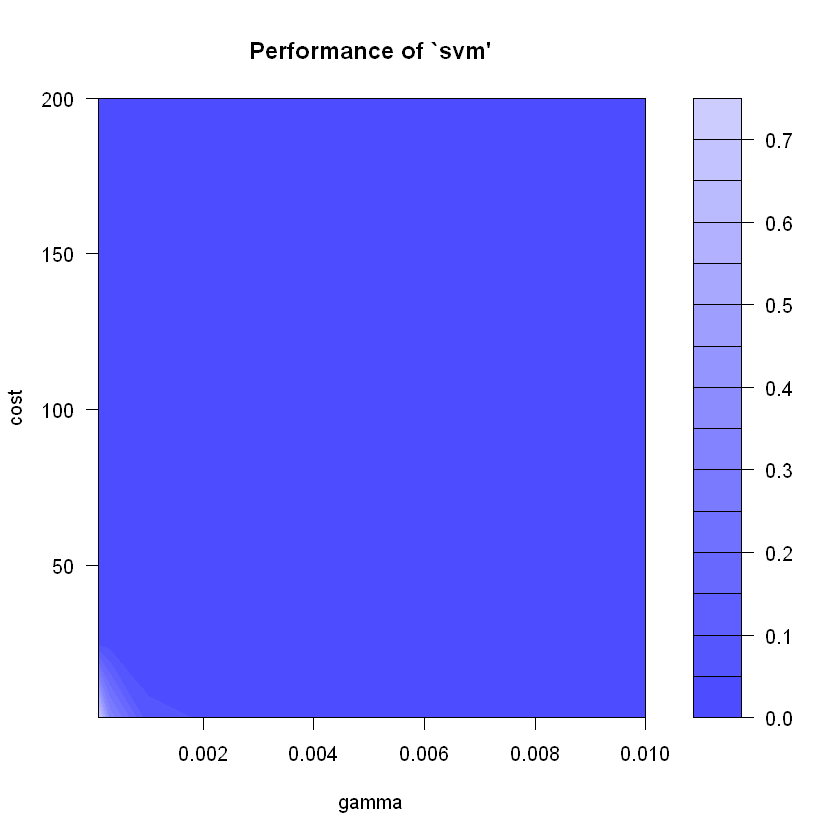

In [ ]:
svm.reg.tune = tune.svm(Calories_Burned ~ ., data = gym_train_scaled, cost = c(1, 25, 50, 75, 100, 150, 200), 
    gamma = 10^seq(-4, -2, by = 0.5))
plot(svm.reg.tune)
svm.reg.tune

In [34]:
svm.reg.tune


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
       gamma cost
 0.003162278   75

- best performance: 0.009527797 


In [82]:
# Best model
svm.reg <- svm.reg.tune$best.model

# Predictions
pred.svm.reg <- predict(svm.reg, newdata=gym_test_scaled)

# Evaluate the model
cat("SVM Regression Model\n")
cat("MSE on test set: ", mean((gym_test_scaled$Calories_Burned - pred.svm.reg)^2), "\n")

SVM Regression Model
MSE on test set:  0.007987394 


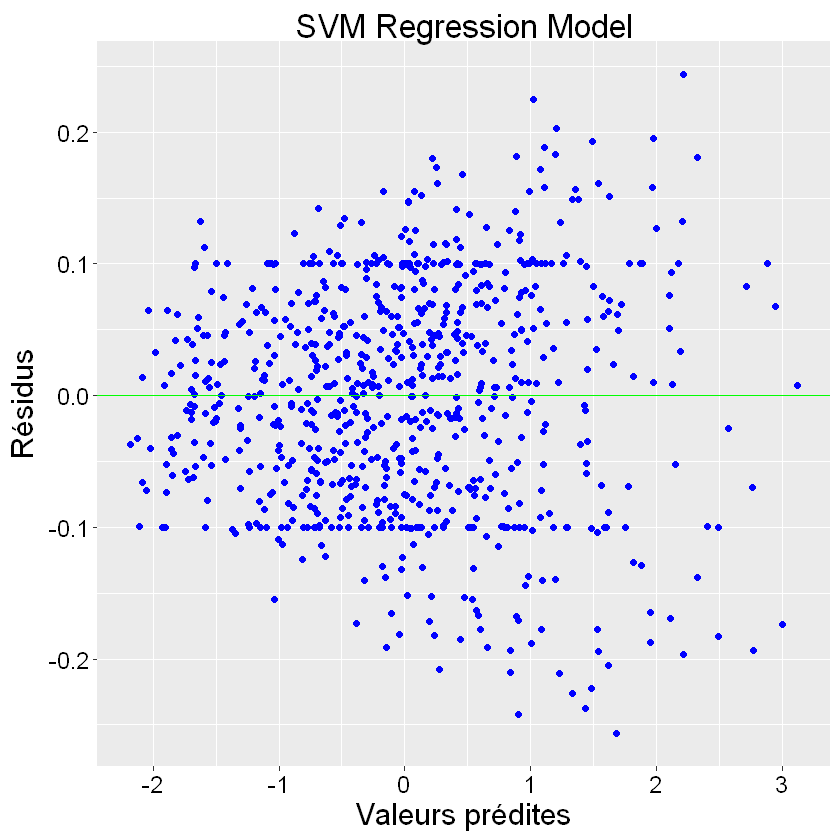

In [44]:
# graphe des résidus
fit.svm.reg = svm.reg$fitted
res.svm.reg = fit.svm.reg - gym_train_scaled$Calories_Burned
gplot.res(fit.svm.reg, res.svm.reg, "SVM Regression Model")

### Regression Trees

- Fit a decision tree regressor.
- Prune the tree using cross-validation.
- Plot: Decision tree structure.

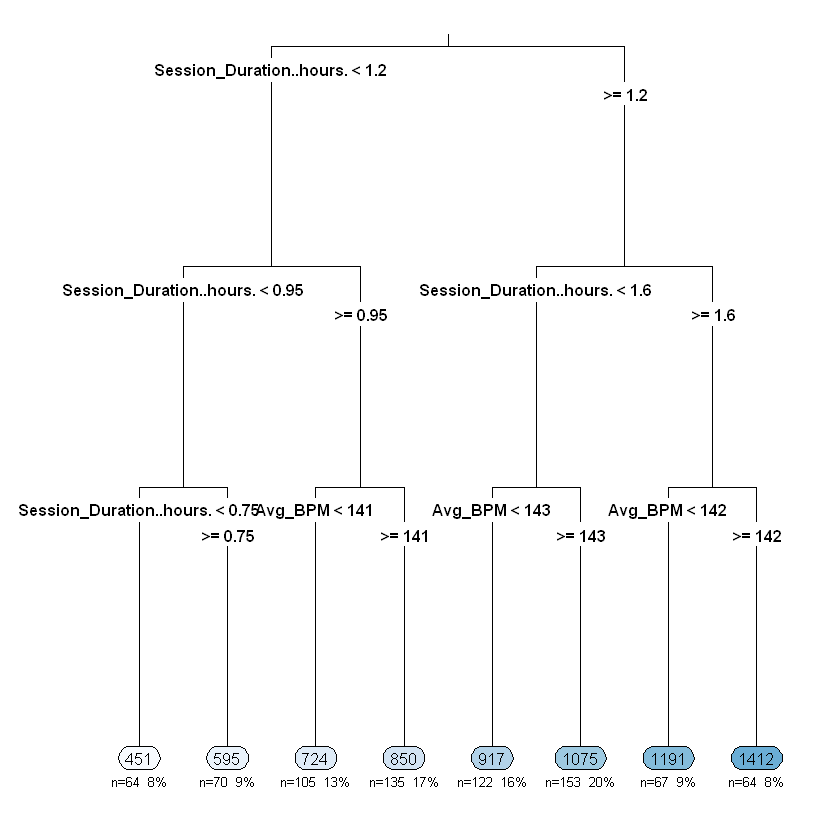

In [16]:
# Fit a regression tree model
library(rpart)
library(rpart.plot)

# Fit a regression tree model for Calories_Burned
fit_calories <- rpart(Calories_Burned ~ ., data = gym_train_calories, method = "anova")

# Plot the tree
rpart.plot(fit_calories, extra = 101, type = 3, under = TRUE, cex = 0.8, tweak = 1)


### Regularization (pruning trees)

### Random Forests
- Using Bootsratp
- **plot** feature importance

### XGBoost
- Optimize number of trees and learning rate.
- Use early stopping to prevent overfitting.
- Plot: SHAP values for interpretability.